ANOVA for Abalone dataset

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trust worthy. It’s important to note the the assumptions apply to the residuals and not the variables themselves. The ANOVA assumptions are the same as for linear regression and are:


1.   Normality
2.   Homogeneity of variance
3.   Independent observations



Dane, które postanowiliśmy analizować to dane dotyczące uchowców. Na początek postanowiliśmy sprawdzić czy długość uchowca ma wpływ na jego płeć. Na początek wczytujemy dane i wybieramy po 1000 próbek dla każdej z płci.

In [0]:
import pandas as pd

data_url='https://raw.githubusercontent.com/codevibess/abalone-anova/master/data/abalone.data'
df = pd.read_csv(data_url)
a = df[df.Sex == "M"].head(1000)
b = df[df.Sex == 'F'].head(1000)
c = df[df.Sex == 'I'].head(1000)
df = a.append(b).append(c)

print(df)

     Sex  Length  Diameter  ...  Viscera weight  Shell weight  Rings
0      M   0.455     0.365  ...          0.1010        0.1500     15
1      M   0.350     0.265  ...          0.0485        0.0700      7
3      M   0.440     0.365  ...          0.1140        0.1550     10
8      M   0.475     0.370  ...          0.1125        0.1650      9
11     M   0.430     0.350  ...          0.0810        0.1350     10
...   ..     ...       ...  ...             ...           ...    ...
3106   I   0.300     0.220  ...          0.0260        0.0315      5
3107   I   0.370     0.275  ...          0.0505        0.0680      5
3108   I   0.375     0.285  ...          0.0400        0.0725      7
3109   I   0.380     0.290  ...          0.0465        0.0750      7
3110   I   0.395     0.300  ...          0.0680        0.0895      8

[3000 rows x 9 columns]


Następnie dzielimy dane na grupy oraz wyznaczamy ilość danych oraz ilosć w poszczególnych grupach

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Length'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()


Kolejnym krokiem jest wyznaczenie statystyki testowej F oraz wartosći p-value korzystając z biblioteki SciPy

In [0]:
#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)

#prawdopodobieństwo hipotezy zerowej wyszło 3.0881829496997467e-232, oznacza to, że średnia długość uchowca róźni się miedzy grupami 

F =  640.2077341389622 prawdopodobieństwo hipotezy zerowej =  3.0881829496997467e-232


Możemy zauważyć, że 
Kolejnym krokiem było analizy wariancji bez uzycia biblioteki SciPy

In [0]:
#teraz anova bez biblioteki
#njpierw obliczamy stopnie swobody
DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

#suma kwadratów odchyleń pomiędzy grupami

SSbetween  = (sum(df.groupby(['Sex']).sum()['Length']**2)/n1)- (df['Length'].sum()**2)/N

#print("SSBetween: "+str(SSbetween))
#suma kwadratów odchyleń wewnątrzgrupowych
sum_y_squared = sum([value**2 for value in df['Length'].values])
SSwithin = sum_y_squared - sum(df.groupby('Sex').sum()['Length']**2)/n1
#print("SSWithin: "+str(SSwithin))
# Ogólnie
SStotal = sum_y_squared - (df['Length'].sum()**2)/N
#średnie kwadraty odchyleń
MSbetween = SSbetween/DFbetween
MSwithin = SSwithin/DFwithin

#Wartość F statystyki testowej
F = MSbetween/MSwithin

#p-value
p = stats.f.sf(F, DFbetween, DFwithin)

eta_sqrd = SSbetween/SStotal
om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

results = {'sum_sq':[SSbetween, SSwithin],
           'df':[DFbetween, DFwithin],
           'F':[F, ''],
            'PR(>F)':[p, ''],
          'EtaSq':[eta_sqrd, ''],
          'OmegaSq':[om_sqrd, '']}

aov_table1 = pd.DataFrame(results, 
                          index=['Group', 'Residual'])
    
aov_table1


,sum_sq,df,F,PR(>F),EtaSq,OmegaSq
Group,13.191573,2,640.208,3.08818e-232,0.299343,0.298806
Residual,30.876809,2997,,,,


Następnie przeprowadzamy analizę pomiędzy poszczególnymi grupami. Analiza zostaje przeprowadzona na poziomie ufności 99%. 

In [0]:
#Teraz sprawdzimy poszczególne grupy

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

MultiComp = MultiComparison(df['Length'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())

#Widać na podstawie danych, że średnie miedzy poszczególnymi grupami róźnią się od siebie na poziomie ufnośći 99%

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     F      I  -0.1513 0.001 -0.1645 -0.1381   True
     F      M  -0.0245 0.001 -0.0377 -0.0113   True
     I      M   0.1268 0.001  0.1136    0.14   True
---------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Oznacza to, że długość uchowca doskonale określa płeć uchowca. Ponizej przedstawiamy wykresy pudełkowe dla poszczególnych płci:

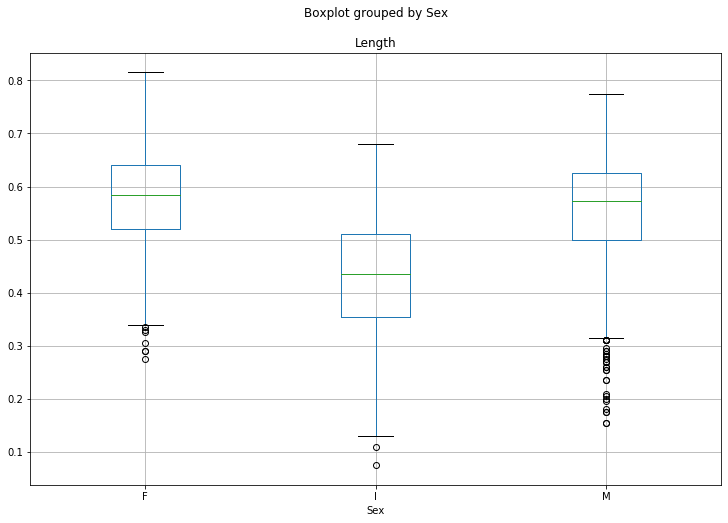

In [0]:
df.boxplot('Length', by='Sex', figsize=(12, 8))

Możemy zauważyć , że najbardziej zbliżone są do siebie płeć męska i żeńska. Ogólnie mamt też mało obserwacji nietypowych. Jednak najwięcej jest ich dla płci męskiej. Jeżeli będziemy klasyfikować płeć uchowca na podstawie jego długosci to niektóre płci męskie i żeńskie będziemy klasyfikować jako dziecko.

Teraz przeprowadzimy 1 czynnikową analizę wariancji ze wzgledu na wysokość uchowca

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Height'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()

#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)


MultiComp = MultiComparison(df['Height'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())


F =  521.5486634576289 prawdopodobieństwo hipotezy zerowej =  4.334418114792542e-195
Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     F      I  -0.0503 0.001 -0.0552 -0.0455   True
     F      M  -0.0081 0.001  -0.013 -0.0032   True
     I      M   0.0423 0.001  0.0374  0.0472   True
---------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Oznacza to, że Wysokość uchowca doskonale określa płeć uchowca. Ponizej przedstawiamy wykresy pudełkowe dla poszczególnych płci:

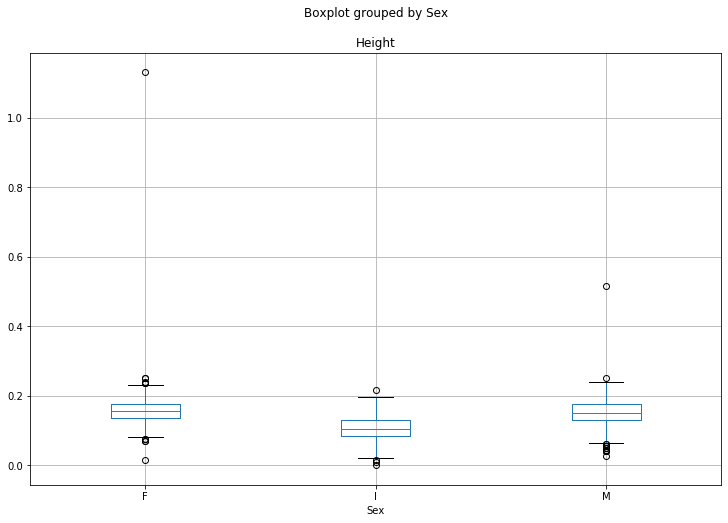

In [0]:
df.boxplot('Height', by='Sex', figsize=(12, 8))

Możemy zauważyć , że najbardziej zbliżone są do siebie płeć męska i żeńska tak jak w przypadku długości Ogólnie mamy też mało obserwacji nietypowych. Jednak najwięcej jest ich dla płci męskiej jak w przypadku długości. Jeżeli będziemy klasyfikować płeć uchowca na podstawie jego długosci to niektóre płci męskie i żeńskie będziemy klasyfikować jako dziecko.

Teraz przeprowadzimy 1 czynnikową analizę wariancji ze wzgledu na pierścień uchowca

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Rings'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()

#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)




MultiComp = MultiComparison(df['Rings'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())

F =  369.97385454679113 prawdopodobieństwo hipotezy zerowej =  2.502237830311564e-144
Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     F      I    -3.33  0.001 -3.7221 -2.9379   True
     F      M   -0.354 0.0232 -0.7461  0.0381  False
     I      M    2.976  0.001  2.5839  3.3681   True
----------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Można stwierdzić jak widać w tabeli, że średnie róźnią się istotnie. Jednak w przypadku porównania średnich w grupie męskiej i żeńskiej nie możemy tego stwierdzić na tym poziomie ufności. Oznacza to, że Wysokość uchowca doskonale określa płeć uchowca poza porównaniem płci męskiej i żeńskiej. Poniżej model pudełkowy:

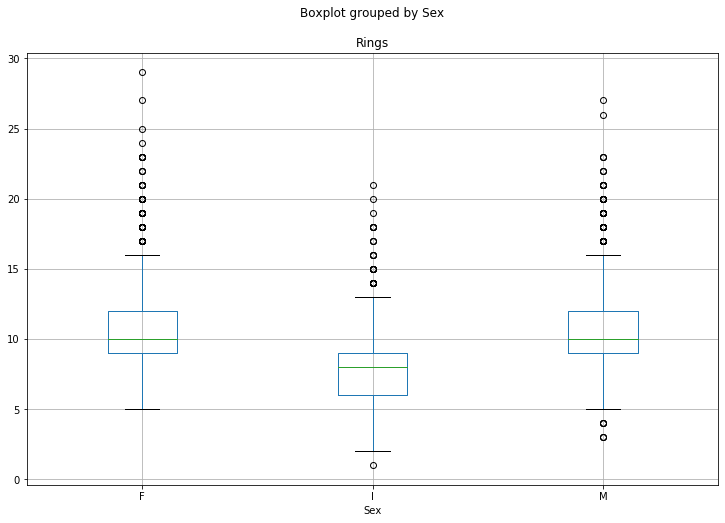

In [0]:
df.boxplot('Rings', by='Sex', figsize=(12, 8))

Możemy zauważyć, że najbardziej zbliżone są do siebie płeć męska i żeńska, co może tłumaczyć, że nie nie możemy odrzucić hipotezy zerowej na korzyść hipotezy alternatywnej. Mamy tez trochę wartosci nietypowych jednak są one równomierne dla każdej płci.

Two way anova nie jest dobra dla naszych danych, ponieważ tak naprawdę mamy tylko jedną cechę, która może być etykietą do klasyfykacji. Przejdziemy teraz do analizy składowych głównych, czyli metodę kompresji danych poprzez redukcję wymiarowości. Dzięki redukcji wymiarowości oszczędzamy pamięć, osiągamy lepszą skuteczność oblczeniową algorytmów oraz możemy też uzyskać lepszą wydajność predykcyjną poprzez ograniczenie tzw "klątwy wymiarowości". 

Zadaniem PCA jest wyszukiwanie kierunków maksymalnej wariancji w wielowymiarowej przestrzeni i rzutowanie ich na nową podprzestrzeń zawierającą tyle samo lub mniej wymiarów. PCA składa się z kilku etapów:
1. Standaryzacja danych
2. Utworzenie macierzy kowariancji
3. Rozkład macierzy kowariancji na wektory własne i wartości własne
4. Szeregowanie malejąco wartości własnych tak, aby pasowały do wektorów własnych
5.Wybór k wektorów własnych odpowiadających k największym wartościom własnym, gdzie k oznacza wymiarowość nowej podprzestrzeni cech.
6. Utworzenie macierzy rzutowania W z k najlepszych wektorów własnych
7. Przekształcenie d-wymiarowego początkowego zbioru danych X za pomocą rzutowania W w celu uzyskania nowej k-wymiarowej podprzestrzeni cech.

Zaczniemy od standaryzacji

In [0]:
data_url='https://raw.githubusercontent.com/codevibess/abalone-anova/master/data/abalone.data'
df = pd.read_csv(data_url)
a = df[df.Sex == "M"].head(1000)
b = df[df.Sex == 'F'].head(1000)
c = df[df.Sex == 'I'].head(1000)
df = a.append(b).append(c)

from sklearn.model_selection import train_test_split
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

#Dzielimy dane na 70% uczącyh i 30% testowych

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

#standaryzacja
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

Następny etap to stworzenie macierz kowariancji oraz wyznacznie wartości własnych i wektory własnych

In [0]:
import numpy as np

m_cov = np.cov(X_train_std.T)
e_val, e_vecs = np.linalg.eig(m_cov)
print(f"Wartości własne {e_val}")
print(f"Wektory własne {e_vecs}")

Wartości własne [6.64219723e+00 6.87355072e-01 3.38443347e-01 1.74023294e-01
 8.17291891e-02 6.25698289e-02 1.13233164e-02 6.17006155e-03]
Wektory własne [[-3.73418637e-01 -7.51721262e-02  2.82402859e-02 -6.09376734e-01
  -1.26621766e-02  2.21515805e-02 -6.94314516e-01  6.81801179e-03]
 [-3.74962196e-01 -4.51644005e-02  1.99388601e-02 -5.82566901e-01
   4.57978760e-02  1.68202764e-03  7.17943441e-01  6.22232265e-03]
 [-3.24460026e-01  8.68643796e-02 -9.28421419e-01  1.56400547e-01
  -2.44973769e-02 -7.60583196e-03 -9.72269945e-03  5.54484620e-04]
 [-3.80292066e-01 -1.36801328e-01  1.65762866e-01  2.67183960e-01
   2.98846453e-02 -1.08359065e-01 -4.05510400e-03  8.51555942e-01]
 [-3.63926544e-01 -3.05719772e-01  1.54340282e-01  2.37802436e-01
  -4.17754804e-01 -6.12420062e-01  1.07472899e-02 -3.79511604e-01]
 [-3.70642845e-01 -1.78588094e-01  1.58253164e-01  2.62661629e-01
  -3.00340064e-01  7.79036041e-01  2.29741333e-02 -1.97650853e-01]
 [-3.72820699e-01  5.29882213e-02  1.56764440e-0

Chcemy zmniejszyć wymiarowść zestawu danych kompresując go do nowej podprzestrzeni cech, dlatego interesuje nas jedynie podzbiór wektorów własnych czyli główych składowych zawierających najwięcej informacji czyli wariancję. Wartości włąsne definiują rozmiar wektorów własnych dlatego szeregujemmy je w kolejnośći malejącej. Będziemy szukać k najwiekszych wektorów. Zanim to zrobimy narysujemy wykres współczynników wariancji wyjaśnionej dla wartości własnych.

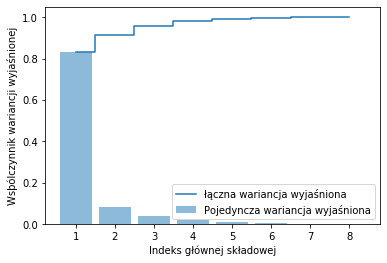

In [0]:
tot = sum(e_val)
var_exp = [(i/tot) for i in sorted(e_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


import matplotlib.pyplot as plt

plt.bar(range(1,9), var_exp, alpha=0.5, align='center', label = 'Pojedyncza wariancja wyjaśniona')
plt.step(range(1,9), cum_var_exp, where='mid', label='łączna wariancja wyjaśniona')
plt.ylabel('Wsþólczynnik wariancji wyjaśnionej')
plt.xlabel('Indeks głównej składowej')
plt.legend(loc='best')
plt.show()

Możemy zauważyć, że sama pierwsza składowa stanowi ponad 80% wariancji wyjaśnionej.

Teraz zajmiemy się ostatnimi trzema punktami. Wybierzemy k wektorów własnych, co odpowiada k największych wartości własnych. k - wymiarowość podprzestrzeni nowej cechy. Zredukujemy do 2 cech. Następnie stworzymy macierz rzutowania W z najważniejszych 2 - wektorów własnych. Na koniec przekształcimy 8- wymiearowy zestaw danych wejściowych w 2-wymiarową podprzestrzęn cech.

In [0]:
#tworzymy pary (wartość włąsna, wektor własny)
e_pairs = [(np.abs(e_val[i]), e_vecs[:, i]) for i in range(len(e_val))]
#sortujemy w kolejności malejącej
e_pairs.sort(key= lambda k: k[0], reverse=True)

#tworzymy macierz W
w = np.hstack((e_pairs[0][1][:, np.newaxis], e_pairs[1][1][:, np.newaxis]))
print(f"macierz W: {w}")

macierz W: [[-0.37341864 -0.07517213]
 [-0.3749622  -0.0451644 ]
 [-0.32446003  0.08686438]
 [-0.38029207 -0.13680133]
 [-0.36392654 -0.30571977]
 [-0.37064285 -0.17858809]
 [-0.3728207   0.05298822]
 [-0.24749058  0.91535964]]


Teraz przenosimy próbkę x (jako wektor 1x8) w potprzestrzeń PCA i uzyskamy dwuwymiarową daną.

In [0]:
X_train_pca = X_train_std.dot(w)
X_test_pca = X_test_std.dot(w)
print(X_train_pca)

[[ 1.24772222  1.27797464]
 [ 5.372003   -0.28048661]
 [ 2.14611774  0.83690575]
 ...
 [ 1.36022651 -0.16116903]
 [-1.89334978  1.84357466]
 [-0.79635667 -0.54953765]]


Teraz zwizualizujemy nasze zredukowane dane:

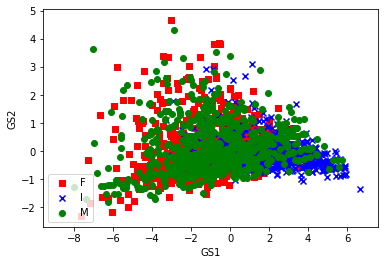

In [0]:
colors = ['r', 'b', 'g']
markers = ['s','x','o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel("GS1")
plt.ylabel("GS2")
plt.legend(loc="lower left")
plt.show()

Widać wyraźnie na wykresie, że mimo zredukowania cech, cięźko będzie klasyfikować dane ponieważ duża część nachodzi na siebie.

Spróbujemy sklasyfikować dane niezredukowane oraz zredukowane żeby zobaczyć czy poprawiła się skuteczność klasyfikacji. Skorzystamy z klasyfikatora KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

print(knn.score(X_test_std, y_test))

knn2 = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn2.fit(X_train_pca, y_train)

print(knn2.score(X_test_pca, y_test))


0.5411111111111111
0.49444444444444446


Możemy zauważyć, że skuteczność predykcji niestety pogorszyła sie z 55% na 49%. Analiza składowych głównych dla redukcji danych do dwóch cech niestety nie pomogła.

Podsumowująć analiza wariancji jest bardzo dobrym narzędziem do sprawdzenia czy średnie w wydzielonych grupach róźnią się. Jeżeli tak będzie możemy przypuszczać, że będzie można stworzyć dobry model do klasyfikacji. Analiza składowych głównych pomaga w redukcji wymiarowości , czyli kompresji danych ale także może przyczynić sie do poprawy predykcji. Niestety w naszym przypadku to się nie udało.

     Length  Diameter  Height  ...  Viscera weight  Shell weight  Rings
Sex                            ...                                     
M     0.455     0.365   0.095  ...          0.1010         0.150     15
M     0.350     0.265   0.090  ...          0.0485         0.070      7
F     0.530     0.420   0.135  ...          0.1415         0.210      9
M     0.440     0.365   0.125  ...          0.1140         0.155     10
I     0.330     0.255   0.080  ...          0.0395         0.055      7
..      ...       ...     ...  ...             ...           ...    ...
M     0.665     0.535   0.195  ...          0.3880         0.480     14
M     0.535     0.435   0.150  ...          0.1385         0.250      9
M     0.470     0.375   0.130  ...          0.1320         0.145      8
M     0.470     0.370   0.130  ...          0.1330         0.165      7
F     0.475     0.375   0.125  ...          0.0850         0.155     10

[100 rows x 8 columns]
     Length  Diameter  Height  ...  Visc

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2346, but rank is 87
  'rank is %d' % (J, J_), ValueWarning)


                           sum_sq      df         F    PR(>F)
C(Length)                0.369190    51.0  0.036752  0.964033
C(Diameter)              8.504983    46.0  0.938677  0.420352
C(Length):C(Diameter)  840.970045  2346.0  1.819923  0.136171
Residual                 2.166667    11.0       NaN       NaN


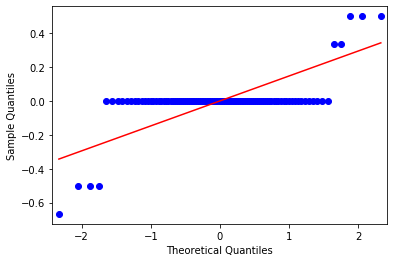

In [0]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pandas as pd
import math
import matplotlib.pyplot as plt

data_url='https://raw.githubusercontent.com/codevibess/abalone-anova/master/data/abalone.data'
df = pd.read_csv(data_url,index_col=0)
df=df.head(100)
print(df)
df.replace(to_replace = [1,2,3,4,5,6,7,8], value=0,inplace=True) 
df.replace(to_replace = [9,10,11,12,13,14,15],value=1, inplace=True) 
df.replace(to_replace = [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],value=2, inplace=True) 



print(df)




formula = 'Rings~C(Length)+C(Diameter)+C(Length):C(Diameter)'
# model = ols(formula, df.take([0,1,7], axis=1)).fit()
model = ols(formula, df.take([7,0,1], axis=1)).fit()
aov_table = anova_lm(model, typ=2)

print(aov_table)

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table)
omega_squared(aov_table)

# print(aov_table.round(4))

res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [0]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(y_train.size):
    if y_train[i] == 'F':
        y_train[i]='M'

for i in range(y_test.size):
    if y_test[i] == 'F':
        y_test[i]='M'

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

print(knn.score(X_test_std, y_test))


0.8111111111111111
